In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
matplotlib.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)

In [3]:
def evaluate_preds(train_true_values, train_pred_values, val_true_values, val_pred_values):
    """
    Функция для оценки работы модели
    Parameters:
    train_true_values - целевая переменная из тренировочной части датасета
    train_pred_values - предсказания модели по тренировочной части
    val_true_values - целевая переменная из валидационной части датасета
    val_pred_values - предсказания модели по валидационной части
    Returns:
    R2 на тренировочной и валидационной части, 
    графики зависимости истинных значений от предсказаний
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Valid R2:\t" + str(round(r2(val_true_values, val_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=val_pred_values, y=val_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    plt.show()

In [4]:
TRAIN_DATASET_PATH = 'datasets/project_task/train.csv'
TEST_DATASET_PATH = 'datasets/project_task/test.csv'

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
display(train_df.tail())
print(train_df.shape)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.402,30.476,5.0,6,5.0,1968,0.136,B,B,46,7960,6,350.0,3,11,B,196684.316
9996,6159,18,1.0,41.522,20.539,9.0,13,13.0,2000,0.000,B,B,30,5562,0,NaN,0,5,A,189050.290
9997,5123,27,1.0,47.939,NaN,1.0,12,16.0,2015,0.072,B,B,2,629,1,NaN,0,0,A,159143.805
9998,5400,75,2.0,43.603,33.840,8.0,1,5.0,1961,0.307,B,A,30,5048,9,325.0,2,5,B,181595.340
9999,6306,128,1.0,38.667,21.158,8.0,7,17.0,1990,0.000,B,B,27,4798,0,30.0,2,8,B,218714.078


(10000, 20)


In [6]:
test_df = pd.read_csv(TEST_DATASET_PATH)
display(test_df.tail())
print(test_df.shape)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.134,50.810,6.0,5,9.0,1973,1.697e-04,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198,21.807,10.0,12,17.0,2017,7.122e-03,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842,48.283,9.0,23,22.0,1989,9.080e-02,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305,NaN,0.0,4,0.0,1977,7.216e-02,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.556,NaN,1.0,10,17.0,1977,7.815e-05,B,B,22,6398,141,1046.0,3,23,B


(5000, 19)


In [7]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [8]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000,10000.000,7887.000,10000.000,10000.000,10000.000,1.000e+04,10000.000,10000.000,10000.000,10000.000,5202.000,10000.000,10000.000,10000.000
mean,1.891,56.316,37.200,6.273,8.527,12.609,3.990e+03,0.119,24.687,5352.157,8.039,1142.904,1.319,4.231,214138.857
std,0.840,21.059,86.241,28.561,5.241,6.776,2.005e+05,0.119,17.533,4006.800,23.832,1021.517,1.494,4.806,92872.294
min,0.000,1.137,0.371,0.000,1.000,0.000,1.910e+03,0.000,0.000,168.000,0.000,0.000,0.000,0.000,59174.778
25%,1.000,41.775,22.770,1.000,4.000,9.000,1.974e+03,0.018,6.000,1564.000,0.000,350.000,0.000,1.000,153872.634
50%,2.000,52.513,32.781,6.000,7.000,13.000,1.977e+03,0.075,25.000,5285.000,2.000,900.000,1.000,3.000,192269.645
75%,2.000,65.901,45.129,9.000,12.000,17.000,2.001e+03,0.196,36.000,7227.000,5.000,1548.000,2.000,6.000,249135.462
max,19.000,641.065,7480.592,2014.000,42.000,117.000,2.005e+07,0.522,74.000,19083.000,141.000,4849.000,6.000,23.000,633233.467


In [9]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000,5000.000,3959.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,2623.000,5000.000,5000.000
mean,1.910,56.450,36.159,5.977,8.632,12.601,1984.393,0.120,24.934,5406.900,8.263,1146.657,1.319,4.243
std,0.839,19.093,17.825,9.950,5.483,6.789,18.573,0.120,17.532,4026.615,23.864,1044.744,1.480,4.777
min,0.000,1.379,0.333,0.000,1.000,0.000,1908.000,0.000,0.000,168.000,0.000,0.000,0.000,0.000
25%,1.000,41.906,23.092,1.000,4.000,9.000,1973.000,0.020,6.000,1564.000,0.000,325.000,0.000,1.000
50%,2.000,52.921,32.925,6.000,7.000,12.000,1977.000,0.072,25.000,5285.000,2.000,900.000,1.000,3.000
75%,2.000,66.285,45.174,9.000,12.000,17.000,2000.000,0.196,36.000,7287.000,5.000,1548.000,2.000,6.000
max,17.000,223.454,303.071,620.000,78.000,99.000,2020.000,0.522,74.000,19083.000,141.000,4849.000,6.000,23.000


In [10]:
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = 10
test_df.loc[test_df['LifeSquare'] < 10, 'LifeSquare'] = 10

In [11]:
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
test_df.loc[test_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [12]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = test_df['HouseFloor'].median()

In [13]:
train_floor_outliers = train_df[train_df['Floor'] > train_df['HouseFloor']].index
train_df.loc[train_floor_outliers, 'Floor'] = train_df.loc[train_floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

test_floor_outliers = test_df[test_df['Floor'] > test_df['HouseFloor']].index
test_df.loc[test_floor_outliers, 'Floor'] = test_df.loc[test_floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [14]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020
test_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [15]:
train_square_med_diff = (train_df.loc[train_df['LifeSquare'].notnull(), 'Square']
                   - train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare']
                   - train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).median()


train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = (
    train_df.loc[train_df['LifeSquare'].isnull(), 'Square']
    - train_df.loc[train_df['LifeSquare'].isnull(), 'KitchenSquare']
    - train_square_med_diff
)

test_square_med_diff = (test_df.loc[train_df['LifeSquare'].notnull(), 'Square']
                   - test_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare']
                   - test_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).median()


test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = (
    test_df.loc[test_df['LifeSquare'].isnull(), 'Square']
    - test_df.loc[test_df['LifeSquare'].isnull(), 'KitchenSquare']
    - test_square_med_diff
)

In [16]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = test_df['Healthcare_1'].median()

In [17]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

In [18]:
train_district_size = train_df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

test_district_size = test_df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

In [19]:
train_df = train_df.merge(train_district_size, on='DistrictId', how='left')
test_df = test_df.merge(test_district_size, on='DistrictId', how='left')

In [20]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [21]:
(test_df['DistrictSize'] > 100).value_counts()

False    3375
True     1625
Name: DistrictSize, dtype: int64

In [22]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)
test_df['IsDistrictLarge'] = (test_df['DistrictSize'] > 100).astype(int)

In [23]:
train_df['DistrictId'] = test_df['DistrictId'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [24]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 
                 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

new_feature_names = ['IsDistrictLarge']

target_name = 'Price'

In [25]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=42)

X_valid = test_df[feature_names + new_feature_names]

In [26]:
from xgboost import XGBRegressor

def xgb_model(X, y):
    gsc = GridSearchCV(
        estimator=XGBRegressor(),
        param_grid={
            'n_estimators': [500],
            'learning_rate': [0.05],
            'gamma': [0],
            'subsample': [0.75],
            'colsample_bytree': [1],
            'max_depth': [6],
            'objective': ['reg:squarederror'], 
        },
        verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    return grid_result.best_params_

In [27]:
%%time
best_params = xgb_model(X_train, y_train)

CPU times: user 8.01 s, sys: 128 ms, total: 8.13 s
Wall time: 29.8 s


Train R2:	0.938
Valid R2:	0.732


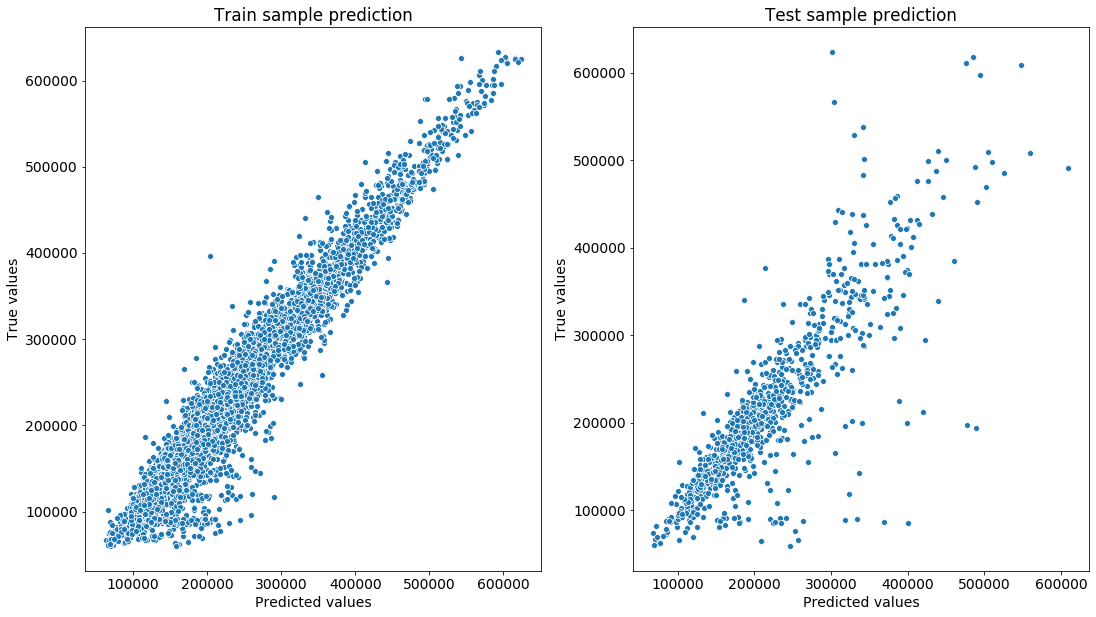

In [28]:
xgb = XGBRegressor(n_estimators=best_params['n_estimators'], 
                   learning_rate=best_params['learning_rate'],
                   gamma=best_params['gamma'],
                   subsample=best_params['subsample'],
                   colsample_bytree=best_params['colsample_bytree'],
                   max_depth=best_params['max_depth'],
                   objective=best_params['objective']
                  )

xgb.fit(X_train, y_train)

y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [29]:
y_valid_preds = xgb.predict(X_valid)

kaggle = pd.concat([test_df['Id'], pd.DataFrame(y_valid_preds, columns=['Price'])], axis = 1)

kaggle.to_csv('result_xgb.csv', index=False)

kaggle.head()

,Id,Price
0,725,164166.828
1,15856,223005.953
2,5480,148756.312
3,15664,366403.094
4,14275,138942.109


In [30]:
from sklearn.ensemble import GradientBoostingRegressor

def gbr_model(X, y):
    gsc = GridSearchCV(
        estimator=GradientBoostingRegressor(),
        param_grid={
            'max_depth': [5],
            'n_estimators': [300],
            'learning_rate': [0.05],
            'min_samples_split': [4],
            'min_samples_leaf': [2]
        },
        verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    return grid_result.best_params_

In [31]:
%%time
best_params = gbr_model(X_train, y_train)

CPU times: user 7.15 s, sys: 60.8 ms, total: 7.21 s
Wall time: 25.2 s


Train R2:	0.867
Valid R2:	0.726


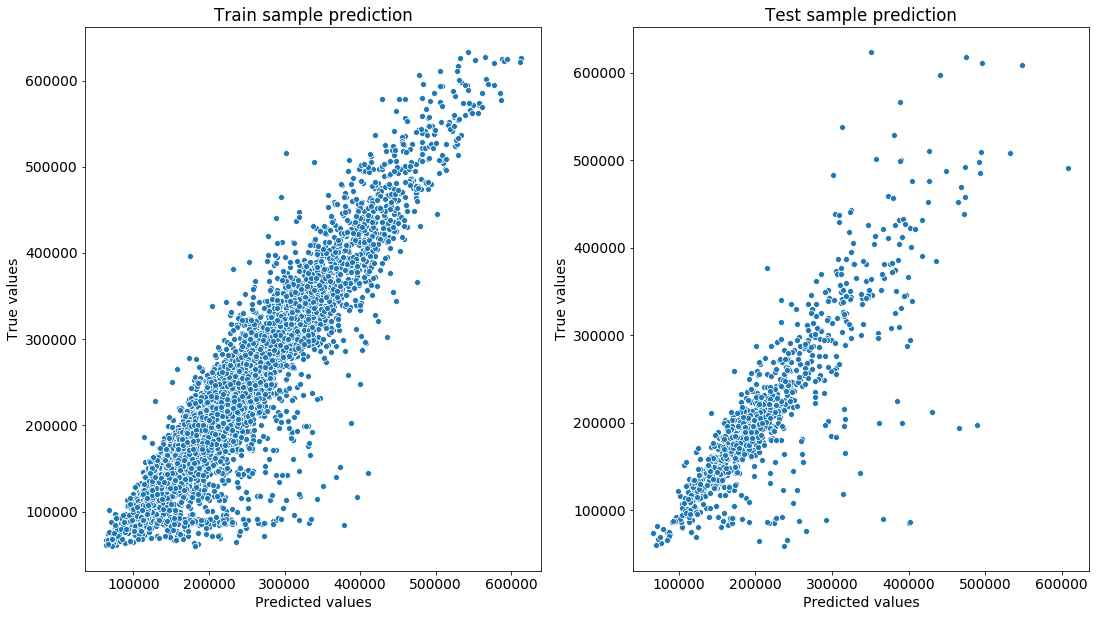

In [32]:
gbr = GradientBoostingRegressor(
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf']
)

gbr.fit(X_train, y_train)

y_train_preds = gbr.predict(X_train)
y_test_preds = gbr.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [33]:
y_valid_preds = gbr.predict(X_valid)

kaggle = pd.concat([test_df['Id'], pd.DataFrame(y_valid_preds, columns=['Price'])], axis = 1)

kaggle.to_csv('result_gbr.csv', index=False)

kaggle.head()

,Id,Price
0,725,163287.177
1,15856,249966.455
2,5480,154785.216
3,15664,363936.941
4,14275,138037.987


# По итогу XGB побить не удалось :(